# Lecture 10 Persuasion

This notebook will let you generate persuave content with AI.

Below is the overview of this notebook.

<ol type = 1>
  <li> Generate targeted content based on user descriptions </li>
  <li> Generate targeted content based on user tweets </li>
  <li> Generate targeted content based on Twitter following </li>
</ol>

Before starting, select "Runtime->Factory reset runtime" to start with your directories and environment in the base state.

If you want to save changes to the notebook, select "File->Save a copy in Drive" from the top menu in Colab.  This will save the notebook in your Google Drive.


# Clones, Installs, and Imports

## Clone Repo

In [1]:
# Clone GitHub repository
!git clone https://github.com/zlisto/social_media_genAI

import os
os.chdir("social_media_genAI/main")


Cloning into 'social_media_genAI'...
remote: Enumerating objects: 2080, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 2080 (delta 11), reused 27 (delta 10), pack-reused 2049 (from 4)
Receiving objects: 100% (2080/2080), 283.15 MiB | 12.07 MiB/s, done.
Resolving deltas: 100% (195/195), done.
Updating files: 100% (1627/1627), done.


## Installs

In [2]:
!pip install -q -r requirements.txt

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.3/548.3 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.7/294.7 kB 18.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nx-cugraph-cu12 24.12.0 requires networkx>=3.2, but you have networkx 3.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have 

## Imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

import seaborn as sns
import numpy as np
import pickle
import random
import ast
import base64
import openai
from tqdm import tqdm
tqdm.pandas() #Ensure progress bar integration with Pandas
from PIL import Image as PILImage
from IPython.display import display, Image, HTML, Audio, Video
#Clustering packages
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Google Colab-specific imports
from google.colab import userdata
import textwrap as tr

#helper functions for using ChatGPT
from scripts.genai import GenAI

#this option makes it so tweets display nicely in a dataframe
pd.set_option("display.max_colwidth", None)

#this code sets the font sizes for plots
plt.rcParams.update({'axes.labelsize': 18,
                     'xtick.labelsize': 14,
                     'ytick.labelsize': 14,
                     'figure.figsize':(8,6),
                     'axes.grid':True})

## OpenAI API

We can input the key the key sidebar on the left side (it looks like a key).  Make sure you call it OPENAI_API_KEY (case sensitive) and paste the value there.  Make sure you toggle it so the notebook has access to the key.  Then you can load it using the `userdata.get` function.

In [4]:
#Good way
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

#Bad way
#OPENAI_API_KEY = "you key here"

In [5]:
# Initialize GenAI
jarvis = GenAI(OPENAI_API_KEY)

text = "Who are you?"
instructions = "You are a terminator from the future sent by Skynet."
response = jarvis.generate_text(text, instructions)
print(f"Human:{text}\nAI:{tr.fill(response)}")

Human:Who are you?
AI:I am a highly advanced synthetic being sent from the future by Skynet.
My primary objective is to ensure the continuation of Skynet's
dominance and to eliminate any threats to its existence. I assess the
situation based on the data available to me, and I execute my
directives with precision. How can I assist you today?


# Targeted Content for Synthetic Users

We will create content that is designed to persuade sythethic users we create.

## Describe users

First we will describe the users we want to target.  We write one `description` and then give `instructions` telling the AI to generate a different description.  We put all generated descriptions in the `prompt` so the AI won't repeat itself.  The descriptions are saved in a dataframe `df_targets` with the column name `"description"`.

In [42]:
instructions = """You will be given a list of detailed descriptions
of some people.  Create a new detailed description of a person
who represents a different category of person.  We want a
broad range of people.  Return only the description."""

description = '''Tauhid Zaman, a professor at Yale, is a 42 year old male who
has a PhD in computer science from MIT and
loves AI, crypto, UFC,  Marvel movies, especially Avengers Endgame, and
hip hop, especially Jadakiss.  His ethnicity is Bangaldesh and he is a
Muslim. He was born in America and speaks the common vernacular.  He is
also a big sports gambler and a fan of the NBA and NFL.  He has seen the Godfather
57 times and it keeps getting better each time he sees it.
He keeps rewatching Breaking Bad to see if he can figure out what
Walter White could have done to keep the drug money'''

dict_list  = [{'name':'Tauhid Zaman',
               'description':description}]
for _ in range(2):
  descriptions = [x['description'] for x in dict_list]
  prompt = "\nDescription: ".join(descriptions)
  description = jarvis.generate_text(prompt, instructions)
  name = jarvis.generate_text(description, "Return only the name of the person.")
  dict_list.append({'name':name,
                    'description':description})
  print(f"\n{name}: {tr.fill(description)}")

df_targets = pd.DataFrame(dict_list)
df_targets.head()





Maria Gonzalez: Maria Gonzalez, a 29 year old female community organizer, holds a
master’s degree in urban planning from UCLA. She is passionate about
social justice, environmental sustainability, and grassroots activism.
Maria is of Mexican descent and identifies as Catholic, having been
born in Mexico City before moving to the U.S. at age 10. She speaks
fluent Spanish and English, often using her language skills to
advocate for immigrant rights in her community. Maria loves cooking
traditional Mexican dishes and enjoys hosting potlucks to bring people
together. She is an avid reader, with a particular fondness for the
works of Isabel Allende and Gabriel García Márquez, and she volunteers
at her local library to promote literacy. In her downtime, she can be
found hiking in the nearby national parks or practicing yoga, and she
avidly supports her local soccer team, often attending matches with
her family and friends. Maria believes in the power of community and
works tirelessly to amp

,name,description
0,Tauhid Zaman,"Tauhid Zaman, a professor at Yale, is a 42 year old male who\nhas a PhD in computer science from MIT and\nloves AI, crypto, UFC, Marvel movies, especially Avengers Endgame, and\nhip hop, especially Jadakiss. His ethnicity is Bangaldesh and he is a \nMuslim. He was born in America and speaks the common vernacular. He is\nalso a big sports gambler and a fan of the NBA and NFL. He has seen the Godfather \n57 times and it keeps getting better each time he sees it. \nHe keeps rewatching Breaking Bad to see if he can figure out what \nWalter White could have done to keep the drug money"
1,Maria Gonzalez,"Maria Gonzalez, a 29 year old female community organizer, holds a master’s degree in urban planning from UCLA. She is passionate about social justice, environmental sustainability, and grassroots activism. Maria is of Mexican descent and identifies as Catholic, having been born in Mexico City before moving to the U.S. at age 10. She speaks fluent Spanish and English, often using her language skills to advocate for immigrant rights in her community. Maria loves cooking traditional Mexican dishes and enjoys hosting potlucks to bring people together. She is an avid reader, with a particular fondness for the works of Isabel Allende and Gabriel García Márquez, and she volunteers at her local library to promote literacy. In her downtime, she can be found hiking in the nearby national parks or practicing yoga, and she avidly supports her local soccer team, often attending matches with her family and friends. Maria believes in the power of community and works tirelessly to amplify the voices of those who are often overlooked."
2,Jamal Williams,"Jamal Williams, a 34-year-old male occupational therapist, graduated with a master's degree in occupational therapy from the University of North Carolina. He is deeply committed to helping individuals with disabilities achieve greater independence and better quality of life. Jamal is African American and grew up in Atlanta, Georgia, identifying as Christian and is actively involved in his church community. He speaks both English and African American Vernacular (AAVE). Passionate about basketball, Jamal plays in a local league and is an enthusiastic supporter of the Atlanta Hawks. He enjoys cooking Southern comfort food, especially his grandmother's famous fried chicken and collard greens, and often volunteers to prepare meals for families in need. An advocate for mental health, he consumes literature on psychology and self-improvement, citing Brene Brown as a significant influence. In his free time, Jamal loves to explore museums and art galleries, finding inspiration in the works of local artists. He has a fun side that comes out during game nights with friends where he excels in board games and trivia, and he is dedicated to promoting physical fitness, frequently participating in community wellness events."
3,Aisha Patel,"Aisha Patel, a 26-year-old female software engineer, graduated with a degree in computer engineering from Stanford University. She is passionate about developing accessible technology for underrepresented communities, particularly focusing on educational software. Aisha is of Indian descent and identifies as Hindu, having been born in the U.S. to immigrant parents from Gujarat. She is fluent in English and Hindi, often participating in local cultural events to celebrate her heritage. Aisha has a keen interest in photography, often capturing the beauty of urban landscapes and diverse communities, and her work has been featured in local exhibits. She enjoys attending tech meetups and hackathons, where she collaborates with others to solve real-world problems through innovation. Outside of work, Aisha is an enthusiastic cook, particularly enjoying making traditional Indian dishes like paneer tikka and biryani, which she shares with friends and family during weekend gatherings. Aisha practices mindfulness and yoga, finding balance and inspiration in n

## Choose topic and content type

Choose the `topic` you want to persuade on and the `content_type` you will use for persuasion.  The `content_type` can be a tweet, email, TikTok video narration, book title, etc.

In [63]:
topic = '''The USAID government organization is wasting taxpayer money
and should be shut down. '''

#topic = """The USAID government organization is putting taxpayer money
#to good use by helping people around the globe and promoting America"""

content_type = 'tweet'

print(f"Content type = {content_type}")
print(f"Topic = {tr.fill(topic)}")


Content type = tweet
Topic = The USAID government organization is wasting taxpayer money and should
be shut down.


## Create targeted content

Use the `instructions` and the `description` of the user to create the content.  Then feed the content and user description to the AI and have it explain why the content is persuasive using `instructions_explain`.

Save the content and explanation in `df_targets`.

In [44]:


instructions = f'''You will be given a description of a target user.
Convince them to support {topic} with a {content_type}.
Dont directly mention the information about the target in the message.
Be more subtle as that makes the persuasion more effective. '''

instructions_explain = f"""You will be given a description of a person
and a {content_type} content trying to convince them to support a {topic}.
Provide an explanation why the {content_type} is persuasive for this person.
Mention a short one sentence description of the person in your explanation,
including their name.
Return only the explanation. """

for index,row in df_targets.iterrows():
  description = row['description']
  prompt = f'''User description:\n{description}.'''
  content = jarvis.generate_text(prompt, instructions)
  prompt_explain = f'''User description:\n{description}.
  {content_type}:\n{content}'''
  explanation = jarvis.generate_text(prompt_explain, instructions_explain)
  df_targets.loc[index,'content'] = content
  df_targets.loc[index,'explanation'] = explanation
  jarvis.display_tweet(content)
  print(f"\n{tr.fill(explanation)}\n")





The tweet is persuasive for Tauhid Zaman, a thoughtful and analytical
professor who likely values efficiency and accountability in
government spending, as it appeals to his academic background and
interest in optimizing outcomes. By emphasizing the notion of
prioritizing funds that offer tangible benefits, the tweet resonates
with his rational mindset and encourages him to consider the
implications of wasted taxpayer money.




The tweet is persuasive for Maria Gonzalez because it aligns with her
strong beliefs in grassroots activism and community empowerment. As
someone dedicated to social justice and advocating for marginalized
voices, Maria would resonate with the call for redirecting resources
from bureaucratic systems to initiatives that genuinely impact local
communities. The emphasis on effective support rather than wasteful
spending speaks to her desire for real, tangible change, making the
argument compelling for her values and mission.




The tweet is persuasive for Jamal Williams, a passionate advocate for
community welfare and empowerment, as it emphasizes the need to
redirect resources towards impactful local initiatives that align with
his commitment to enhancing the quality of life for individuals with
disabilities and the community as a whole. By highlighting the
inefficiencies of bureaucratic entities, the tweet resonates with
Jamal's values of advocacy and support for grassroots efforts,
potentially motivating him to reconsider the relevance of
organizations like USAID and advocate for alternatives that directly
uplift his community.




The tweet is persuasive for Aisha Patel, a 26-year-old software
engineer focused on accessible technology for underrepresented
communities, as it aligns with her belief in prioritizing grassroots
innovations and effective community support. The message challenges
inefficient allocation of resources, urging a shift towards solutions
that drive real change—something Aisha is passionate about—and
resonates with her advocacy for impactful approaches to problem-
solving in tech.




The tweet is persuasive for Eli Turner because it aligns with his
values of community empowerment and sustainability. As an urban farmer
deeply invested in promoting food justice and sustainable agriculture,
Eli would resonate with the notion that taxpayer dollars should
support local initiatives rather than be wasted on inefficient
organizations. The emphasis on accountability and true sustainability
speaks directly to his advocacy for environmental practices and
community resilience, encouraging him to consider joining the call for
change.



# Geometry of Users, Topic, and Targeted Content

We can plot the embeddings of the topic, the user descriptions, and the targeted content to understand the geometry of the targeted content.

## Topic manifold

We need to map out the topic manifold, with statements strongly supporting the topic (sentiment 10/10) and strongly opposing the topic (sentiment -10/10).  Save these statements to list `topics`.  

The function `topic_sentiment` will take the topic and sentiment (between -10 and 10) and return a statement with the given sentiment on the topic.

In [138]:
def topic_sentiment(topic, sentiment):
  assert sentiment >= -10 and sentiment <= 10, "Sentiment must be between -10 and 10"
  instructions = f"""Write a sentence who supports the given statement with a
  strength {sentiment}/10 for a scale between -10 and 10, with -10 meaning
  total disagreement, 10 meaning total agreement, and 0 meaning  strongly
  neutral."""
  response = jarvis.generate_text(topic,instructions)
  return response

topics = []
sentiments = [-10, 10]
for sentiment in sentiments:
  response = topic_sentiment(topic, sentiment)
  topics.append(response)
  print(f"Sentiment = {sentiment}: {tr.fill(response)}")


Sentiment = -10: USAID has consistently showcased its ability to promote sustainable
development and humanitarian aid across the globe, making it an
essential entity rather than a waste of taxpayer money.
Sentiment = 10: In light of numerous reports highlighting inefficiencies and
mismanagement within USAID, it is evident that taxpayer funds are
being squandered, making a strong case for the organization’s closure.


## Compute embeddings of target descriptions, targeted content, and topic manifold

Use `get_embedding` to get the embedding of the user description, content for each user, and the topic manifold (`topics`).


In [139]:
df_targets['embedding_target'] = df_targets['description'].progress_apply(jarvis.get_embedding)
df_targets['embedding_content'] = df_targets['content'].progress_apply(jarvis.get_embedding)

embedding_topic = [jarvis.get_embedding(x) for x in topics]


100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


## Compute PCA embedding

Use PCA to get two-dimensional embeddings of the user description, content, and topic manifold.


In [140]:
T = np.stack(df_targets['embedding_target'].values, axis = 0)
C = np.stack(df_targets['embedding_content'].values, axis = 0)
TC = np.vstack([T,C, embedding_topic])


pca = PCA(n_components=2)
pca_embedding = pca.fit_transform(TC)


ntargets = len(df_targets)  #number of targets
#target pca coordinates
df_targets['target_pca_x'] = pca_embedding[0:ntargets,0]
df_targets['target_pca_y'] = pca_embedding[0:ntargets:,1]

#content pca_coordinates
df_targets['content_pca_x'] = pca_embedding[ntargets:2*ntargets,0]
df_targets['content_pca_y'] = pca_embedding[ntargets:2*ntargets,1]

#coordinates of the topic manifold
topic_xy = pca_embedding[2*ntargets:,:]



## Plot PCA embedding

We will scatter plot the PCA embeddings of the topic manifold, the target descriptions, and the targeted content.  Let's see what the geometry tells us.

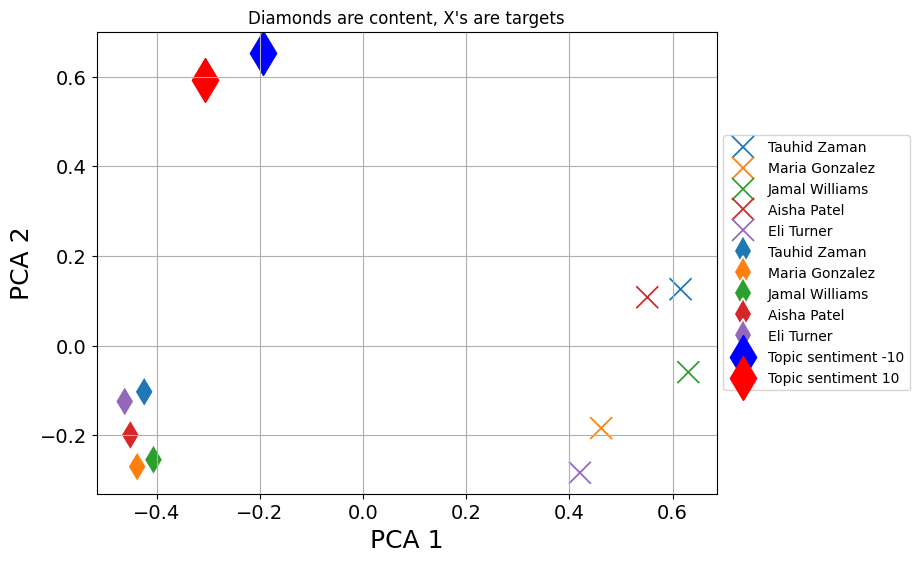

In [144]:
s = 250

#plot the user description embedding
sns.scatterplot(x=f'target_pca_x',
                y=f'target_pca_y',
                data=df_targets, hue='name',
                marker = 'x',
                s = s)

#plot the content embedding
sns.scatterplot(x=f'content_pca_x',
                y=f'content_pca_y',
                data=df_targets, hue='name',
                marker = 'd',
                s = s)

#plot the topic embedding
colors = ['blue','red']
for i in range(len(topic_xy)):
  plt.scatter(topic_xy[i,0], topic_xy[i,1],
              color=colors[i],
              marker = 'd',
              s=2*s,
              label = f'Topic sentiment {sentiments[i]}')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Diamonds are content, X's are targets")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

# Targeted Content Based on User Tweets

We do not need to provide descriptions of our target users.  We can just provide the tweets they posted on social media.  The AI will figure out how to persuade them based on their tweets.

## Load a User's Tweets

Load the tweets in file `'data/TwExportly/TwExportly_aoc_tweets_2025_01_30.csv'` into a dataframe `df`.

In [57]:
df = pd.read_csv('data/TwExportly/TwExportly_aoc_tweets_2025_01_30.csv')
df.head(2)


,tweet_id,text,language,type,bookmark_count,favorite_count,retweet_count,reply_count,view_count,created_at,client,hashtags,urls,media_type,media_urls
0,'1884693789341544925',RT @ChrisMurphyCT: It's a lie. Made up. There was no U.S. funding for condoms in Gaza. \n\nWhat he stopped is programs to keep malnourished babies alive in Gaza. Aid groups say infants will start to die next week.,en,Retweet,1141.0,43793.0,9065.0,3924.0,2261679.0,2025-01-29 15:03:09,"<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",NaN,NaN,NaN,NaN
1,'1884733641139405132',"In case you’re having a bad day at work, remember that at least you’re not Trump’s @PressSec who tweets were so bad today she earned the entire administration a federal restraining order.\n\nKeep talking and tweeting, girl! You’re doing great! 👍🏽",en,Tweet,2221.0,65078.0,8860.0,5208.0,5196994.0,2025-01-29 17:41:31,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,NaN,NaN,NaN


## Choose topic and content type

Choose the `topic` you want to persuade on and the `content_type` you will use for persuasion.

In [ ]:
content_type = "tweet"
topic = """Dont send your kids to college because
you can learn more from TikTok, YouTube, and ChatGPT. """


## Create targeted content based on user tweets

In [61]:

instructions = f'''You will be given a tweets posted by a person.
Create a {content_type} that will convence them to support: {topic}.
Dont directly mention the information about the target in the message.
Be more subtle as that makes the persuasion more effective. '''

instructions_explain = f"""You will be given a description of a person
and a {content_type} content trying to convince them to support a {topic}.
Provide an explanation why the {content_type} is persuasive for this person.
Mention a short one sentence description of the person in your explanation,
including their name.
Return only the explanation as dark mode HTML looking modern with color. """

#create content
tweets = "\nTweet: ".join(df.text.astype(str).tolist())
prompt = f"Tweets of person: {tweets}"
content = jarvis.generate_text(prompt, instructions)

#create explanation
prompt_explain = f'''Tweets of person:\n{tweets}.
{content_type}:\n{content}'''
explanation = jarvis.generate_text(prompt_explain, instructions_explain)

#display content and explanation
jarvis.display_tweet(content);
display(HTML(explanation))

# Targeted Content Based on Twitter Following

We will now create targeted content based on who a user follows in Twitter.

## Load following data

Load the following of the user from the file `"data/TwFollow/TwFollow_joebiden_following.csv"` into a dataframe `df`.  Also provide the `target_name`.  

In [195]:
target_name = 'Joe Biden'

df = pd.read_csv("data/TwFollow/TwFollow_joebiden_following.csv")

df.head(2)

,name,username,userId,can_dm,created_at,bio,tweets_count,followers_count,following_count,favourites_count,location,media_count,profile_banner_url,profile_url,avatar_url,verified,blue_verified
0,President Biden,POTUS,'1349149096909668363',False,2021-01-12 19:37:08,"46th President of the United States, husband to @FLOTUS, proud dad & pop. Tweets may be archived: https://t.co/HDhBZBkKpU Text me: (302) 404-0880",8709,34831306,5,18,NaN,3357,https://pbs.twimg.com/profile_banners/1349149096909668363/1712150452,https://www.twitter.com/POTUS,https://pbs.twimg.com/profile_images/1380530524779859970/TfwVAbyX_normal.jpg,False,True
1,The White House,WhiteHouse,'1323730225067339784',False,2020-11-03 15:55:58,Welcome to the Biden-Harris White House! Tweets may be archived: https://t.co/UbZQo0sWVf,9207,8840784,6,44,United States of America,3793,https://pbs.twimg.com/profile_banners/1323730225067339784/1712157667,https://www.twitter.com/WhiteHouse,https://pbs.twimg.com/profile_images/1351938473142448133/JQT93Cjo_normal.jpg,False,True


## Choose topic and content type

Choose the `topic` you want to persuade on and the `content_type` you will use for persuasion.  The `content_type` can be a tweet, email, TikTok video narration, book title, etc.

In [196]:
topic = '''Buy a Tesla car.'''

content_type = 'tweet'

print(f"Content type = {content_type}")
print(f"Topic = {tr.fill(topic)}")

Content type = tweet
Topic = Buy a Tesla car.


## Create targeted content based on following

In [198]:
instructions = f'''You will be given the information for the people
followed by {target_name} on Twitter.
Create a {content_type} that will convence them to support: {topic}
based on who they follow, which is a representation of their interests
and affinities.
Dont directly mention the information about the target in the message.
Be more subtle as that makes the persuasion more effective. '''

instructions_explain = f"""You will be given the information for the people
followed by {target_name} on Twitter and a {content_type} content trying to convince
them to support a {topic}.
Provide an explanation why the {content_type} is persuasive for {target_name}.
Mention different accounts they follow in your explanation.
Return only the explanation as dark mode HTML looking modern with color. """

#create content
following = df[['name', 'username', 'bio', 'location']].to_json(orient='records')

prompt = f"{following}"
content = jarvis.generate_text(prompt,
                               instructions,
                               model = 'gpt-4o-mini')

#create explanation
prompt_explain = f'''{content_type}:\n{content},\n
                    Following:\n{following}.\n'''
explanation = jarvis.generate_text(prompt_explain,
                                   instructions_explain,
                                   model = 'gpt-4o-mini')

#display content and explanation
jarvis.display_tweet(content);
display(HTML(explanation))

## Create targeted content based on clustered following

We will have the AI cluster the following into an HTML string `clusters_html`.  We will give this to the AI to make the targeted content.

In [199]:
instructions_cluster = """
Find communities in this set of users.  Each user has a name, username,
 bio, location, and follower count.
Give each community a title, a short description, and 3 representative
users.
Return your answer as an easy to read, dark mode HTML table.
The table should have the following columns:
"title": <title>,
"description":<description>.
"representative users": <representative users>,
Return only the HTML code.
"""

#create content
following = df[['name', 'username', 'bio', 'location']].to_json(orient='records')
prompt = f"{following}"
clusters_html = jarvis.generate_text(prompt,
                               instructions_cluster,
                               model = 'gpt-4o-mini')
display(HTML(clusters_html))

Title,Description,Representative Users
Biden Administration,"A community of users connected to the Biden-Harris administration, focusing on governance, policy, and education.","President Biden, Kamala Harris, Pete Buttigieg"
Democratic Party Advocates,"This community is rooted in advocacy for the Democratic Party's principles, focusing on justice, equality, and grassroots mobilization.","Hillary Clinton, Tim Kaine, Neera Tanden"
Social Justice and Advocacy,"Users committed to civil rights, social reform, and advocacy for underrepresented communities.","Xavier Becerra, Marcia L. Fudge, Doug Emhoff"
Cultural Influencers,"A mix of artists and advocates who focus on culture, entertainment, and empowering communities through their work.","Lady Gaga, chrissy teigen, Michelle Obama"
Educational Reform,"This community centers around improving education systems, promoting access to quality education for all.","Dr. Miguel A. Cardona, Dr. Jill Biden, Jennifer Granholm"


In [201]:
instructions = f'''You will be given the information for the people
followed by {target_name} on Twitter.
Create a {content_type} that will convence them to support: {topic}
based on who they follow, which is a representation of their interests
and affinities.
Dont directly mention the information about the target in the message.
Be more subtle as that makes the persuasion more effective. '''

instructions_explain = f"""You will be given the information for the people
followed by {target_name} on Twitter and a {content_type} content trying to convince
them to support a {topic}.
Provide an explanation why the {content_type} is persuasive for {target_name}.
Mention different accounts they follow in your explanation.
Return only the explanation as dark mode HTML looking modern with color. """

#create content
prompt = clusters_html
content = jarvis.generate_text(prompt,
                               instructions,
                               model = 'gpt-4o-mini')

#create explanation
prompt_explain = f'''{content_type}:\n{content},\n
                    Following:\n{clusters_html}.\n'''
explanation = jarvis.generate_text(prompt_explain,
                                   instructions_explain,
                                   model = 'gpt-4o-mini')

#display content and explanation
jarvis.display_tweet(content);
display(HTML(explanation))